In [1]:
# reload magic
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import os 
import numpy as np
from mindreadingautobots.sequence_generators import make_datasets, data_io
import matplotlib.pyplot as plt

In [3]:
# Generate data with bitflip values
seed = 1234 
n_data = 1000000
n_bits = 10 

# Create a different dataset for every 'nondeterministic' value in this list
# Note that _sometimes_ this means bitflip rate, but not always
p_bitflips = [0.01, 0.1, 0.2]
p_bitflips = [0.4]

X, Z, idx = make_datasets.sparity_k4(n_data, n_bits, p_bitflips[0], seed)

In [64]:
# # Generate data with bitflip values
# n_val = 10000 # number of validation examples
# seed = 1234
# n_data = 1000000
# n_bits = 16 # number of TOTAL bits
# # variables
# # p_bitflips = [0, 0.05, 0.1]
# # p_bitflips = [0.15]
# p_bitflips = [0.2]

# def hamilton_6_choose_4(n_data, n_bits, p_bitflip, seed):
#     return make_datasets.k_choose_m_hamilton_forecast_dataset(k=6, m=4, n_data=n_data, n_bits=n_bits, p_bitflip=p_bitflip, seed=seed)


# X, Z, idx = hamilton_6_choose_4(n_data, n_bits, p_bitflips[0], seed)

In [ ]:
def xlogx(x):
    return x * np.log2(x) if x > 0 else 0

def empirical_entropy_estimate(X, intermediate_idx=[-1]):
    """Construct an empirical estimator for the entropy H(X_n|X^{n-1})
    
    This is based purely on an empirical estimate for p_{X_n|X^{n-1}}.
    Thus, at the same time we can approximate the optimal success
    probability for the next bit.

    Returns:
        - entropy_out: entropy estimate for the next bit
        - mle_out: maximum likelihood estimate for the next bit
    """
    # n_data, n_bits = X.shape

    entropy_out = [] # entropy estimate for the next bit
    mle_out = [] # maximum likelihood estimate for the next bit
    lb = 0
    current_total = 0
    # These dicts represent histograms for empirical distribution of X^n and X^{n-1}
    dct_n = {}
    dct_nminus1 = {}
    keys_n = []
    keys_nminus1 = []

    # This will iterate over smaller subsets of data.
    for i in intermediate_idx:
        current_bounds = [lb, i]
        keys_n_new, counts_n = np.unique(X[lb:i,:], axis=0, return_counts=True)
        keys_nminus1_new = np.unique(keys_n_new[:, :-1], axis=0)
        # cast to normal ints.
        keys_n_new = [list([int(x) for x in k]) for k in keys_n_new]
        keys_nminus1_new = [list([int(x) for x in k]) for k in keys_nminus1_new]
        # keep track of the new total data
        slc_n = sum(counts_n)
        current_total += slc_n
        keys_n = list(set(keys_n + [tuple(k) for k in keys_n_new]))
        keys_nminus1 = list(set(keys_nminus1 + [tuple(k) for k in keys_nminus1_new]))

        for k, v in zip(keys_n_new, counts_n):
            if tuple(k) not in dct_n:
                dct_n[tuple(k)] = 0
            dct_n[tuple(k)] += v

            if tuple(k[:-1]) not in dct_nminus1:
                dct_nminus1[tuple(k[:-1])] = 0
            dct_nminus1[tuple(k[:-1])] += v
        
        # estimate entropy from histograms
        H_Xn = 0
        for k, v in dct_n.items():
            p = v / current_total
            H_Xn -= xlogx(p)
        
        H_Xnminus1 = 0
        mle = 0
        for k in keys_nminus1:
            # entropy calculation: H(X^{n-1})
            p = dct_nminus1[k] / current_total
            H_Xnminus1 -= xlogx(p)
            # MLE calculation: Find out whether p_{X_n|X^{n-1}}(0|x^{n-1}) > p_{X_n|X^{n-1}}(1|x^{n-1})
            pr_xnminus1_and_0 =  dct_n.get(tuple(list(k)+[0])) 
            if pr_xnminus1_and_0 is not None and pr_xnminus1_and_0 > 0.5 * p:
                mle += pr_xnminus1_and_0
            else:
                mle += 1 - pr_xnminus1_and_0

        mle_out.append(mle)
        entropy_out.append(H_Xn - H_Xnminus1)

        
        lb = i

    return 

results = empirical_entropy_estimate(Z, intermediate_idx=[10])

[(0, 1, 0, 1, 1, 0, 1, 0, 1, 1), (1, 0, 1, 1, 0, 0, 0, 1, 1, 0), (1, 0, 0, 1, 1, 1, 1, 1, 1, 1), (0, 1, 0, 0, 0, 0, 0, 0, 1, 1), (0, 0, 0, 0, 1, 1, 0, 1, 1, 1), (0, 1, 0, 0, 0, 0, 1, 1, 1, 1), (0, 0, 1, 0, 1, 0, 0, 1, 0, 0), (1, 0, 0, 0, 0, 0, 0, 1, 0, 1), (1, 0, 1, 0, 1, 0, 0, 0, 1, 1), (0, 1, 0, 1, 0, 0, 0, 1, 1, 1)]
[(0, 1, 0, 0, 0, 0, 0, 0, 1), (1, 0, 1, 1, 0, 0, 0, 1, 1), (0, 0, 1, 0, 1, 0, 0, 1, 0), (1, 0, 1, 0, 1, 0, 0, 0, 1), (0, 1, 0, 1, 0, 0, 0, 1, 1), (1, 0, 0, 1, 1, 1, 1, 1, 1), (0, 1, 0, 0, 0, 0, 1, 1, 1), (0, 0, 0, 0, 1, 1, 0, 1, 1), (1, 0, 0, 0, 0, 0, 0, 1, 0), (0, 1, 0, 1, 1, 0, 1, 0, 1)]


In [ ]:
print(keys_n)

NameError: name 'keys_n' is not defined

In [66]:
intermediate_idx = list(range(0, n_data, 50000))
# intermediate_idx = [50, 100]
results = empirical_entropy_estimate(Z, intermediate_idx=intermediate_idx)

Fano's inequality, in this setting, is 
$$
H(X_n|Z^{n-1}) \leq h_2 (p_{err}) + p_{err}\log_2(N - 1) = h_2 (p_{err})
$$
Since $h_2$ is monotonic increasing, then so is $h_2^{-1}$, leading us to the inequality
$$
(1 - p_{err}) = p^* \leq 1 - h_2^{-1}(H(X_n|Z^{n-1}) )
$$
We plot this upper bound below.

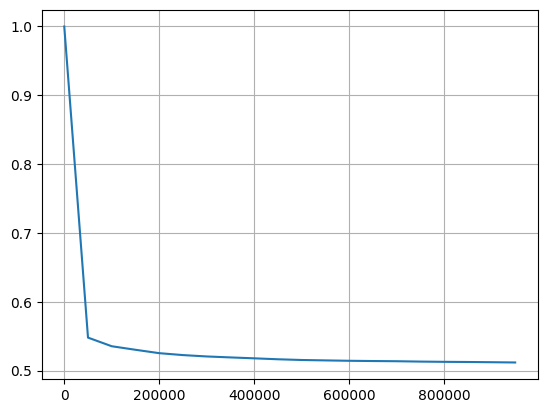

In [67]:
def h2_inverse(y):
    return 0.5 * (1 - np.sqrt(1 - y ** (4/3)))

fig, ax = plt.subplots()
ax.plot(intermediate_idx, 1 - h2_inverse(np.array(results)))
# ax.set_ylim([.8, 1])
ax.grid()